# Notebook for vanilla RNN model

In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util_funcs import load_split_data
from sentence_transformers import SentenceTransformer

from keras.layers import SimpleRNN, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [2]:
# setup PyTorch backend
import os
os.environ['KERAS_BACKEND'] = 'torch'
import torch
print("Using PyTorch backend")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

Using PyTorch backend
Using device: cuda


In [ ]:
# generate data splits
X_train, X_val, X_test, y_train, y_val, y_test = load_split_data("../data/Sentiment_Analysis.csv")

## Sequence embeddings

In [4]:
# embedding model
emb_model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# pad sequences
import nltk
nltk.download("punkt_tab")
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

def process_text_sequences(max_length=40, padding='post', truncating='post'):
    """
    Convert texts to padded sequences of tokens.

    Args:
        max_length: Maximum sequence length (default: 40)
        padding: 'pre' or 'post' padding (default: 'post')
        truncating: 'pre' or 'post' truncation (default: 'post')

    Returns:
        X_train_padded: Padded training sequences
        X_val_padded: Padded validation sequences
        X_test_padded: Padded test sequences
    """
    data = [X_train, X_val, X_test]
    padded_sequences = []

    for texts in data:
        # Tokenize all texts
        sequences = [word_tokenize(text) for text in texts]

        # Convert tokens to numpy arrays with padding
        padded_sequences.append(pad_sequences(
            sequences=[s[:max_length] for s in sequences],  # Truncate if needed
            maxlen=max_length,
            padding=padding,
            truncating=truncating,
            dtype=object,  # Use object dtype for string tokens
            value=''  # Use empty string as padding token
        ))

    return tuple(padded_sequences)

X_train_padded, X_val_padded, X_test_padded = process_text_sequences()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
from functools import cache
@cache
def encode_words(model, text):
    return model.encode(text)

In [7]:
# convert padded sequences to embeddings
def create_embedding_sequences(model, max_length=40):
    """
    Convert sequences of words to sequences of embeddings using cached word vectors.
    Ensures all sequences have the same length through padding.

    Args:
        model: SentenceTransformer model
        max_length: Maximum sequence length (default: 40)
    Returns:
        X_train_embedded: Training embeddings
        X_val_embedded: Validation embeddings
        X_test_embedded: Test embeddings
    """
    data = [X_train_padded, X_val_padded, X_test_padded]
    embeddings = []
    embedding_dim = model.get_sentence_embedding_dimension()

    for sequences in data:
        n_sequences = len(sequences)

        # Initialize the output array with zeros
        embedded_seqs = np.zeros((n_sequences, max_length, embedding_dim))

        for i, seq in enumerate(sequences):
            # Get embeddings for non-empty tokens
            valid_tokens = [word for word in seq if word != '']
            # Truncate if necessary
            valid_tokens = valid_tokens[:max_length]
            # Create embeddings for valid tokens
            seq_embeddings = [encode_words(model, word) for word in valid_tokens]

            # Add embeddings to the output array with padding
            for j, embedding in enumerate(seq_embeddings):
                if j < max_length:
                    embedded_seqs[i, j] = embedding
        embeddings.append(embedded_seqs)
        print(f"Shape: {embedded_seqs.shape}")

    return tuple(embeddings)

In [8]:
%%time
# generate sequence embeddings
X_train_embedded, X_val_embedded, X_test_embedded = create_embedding_sequences(emb_model)

Shape: (24000, 40, 384)
Shape: (8000, 40, 384)
Shape: (8000, 40, 384)
CPU times: user 5min 11s, sys: 1.37 s, total: 5min 13s
Wall time: 5min 12s


## Vanilla RNN

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [10]:
# model 1
rnn_1 = Sequential([
    SimpleRNN(16, input_shape=(40, 384)),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

rnn_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_1.summary()
rnn_1_history = rnn_1.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 16)             │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,909 (26.99 KB)

 Trainable params: 6,909 (26.99 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.2103 - loss: 2.2340 - val_accuracy: 0.2115 - val_loss: 2.1501
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2180 - loss: 2.1536 - val_accuracy: 0.2291 - val_loss: 2.1427
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2373 - loss: 2.1338 - val_accuracy: 0.2406 - val_loss: 2.1425
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2595 - loss: 2.1291 - val_accuracy: 0.2352 - val_loss: 2.1427
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2663 - loss: 2.1196 - val_accuracy: 0.2763 - val_loss: 2.0939
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2759 - loss: 2.0764 - val_accuracy: 0.2974 - val_loss: 2.0299
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3023 - loss: 2.0093 - val_accuracy: 0.2985 - val_loss: 2.0027
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3126 - loss: 1.9844 - val_accuracy: 0.

In [11]:
# model 2
rnn_2 = Sequential([
    SimpleRNN(32, input_shape=(40, 384), return_sequences=True),
    SimpleRNN(32, return_sequences=True),
    SimpleRNN(16),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

rnn_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_2.summary()
rnn_2_history = rnn_2.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 40, 32)         │        13,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 40, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,701 (65.24 KB)

 Trainable params: 16,701 (65.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.2165 - loss: 2.2201 - val_accuracy: 0.2244 - val_loss: 2.1482
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2443 - loss: 2.1351 - val_accuracy: 0.2688 - val_loss: 2.1172
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2423 - loss: 2.1231 - val_accuracy: 0.2512 - val_loss: 2.1201
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2611 - loss: 2.1013 - val_accuracy: 0.2554 - val_loss: 2.1091
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2647 - loss: 2.0968 - val_accuracy: 0.2741 - val_loss: 2.0941
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2664 - loss: 2.0890 - val_accuracy: 0.2736 - val_loss: 2.0848
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2613 - loss: 2.0830 - val_accuracy: 0.2296 - val_loss: 2.1166
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2336 - loss: 2.1064 - val_acc

In [12]:
# model 3
rnn_3 = Sequential([
    SimpleRNN(16, input_shape=(40, 384), return_sequences=True),
    SimpleRNN(16, return_sequences=True),
    SimpleRNN(16, return_sequences=True),
    SimpleRNN(16),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

rnn_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_3.summary()
rnn_3_history = rnn_3.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 40, 16)         │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 40, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 40, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,037 (35.30 KB)

 Trainable params: 9,037 (35.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.2119 - loss: 2.2039 - val_accuracy: 0.2509 - val_loss: 2.1393
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2321 - loss: 2.1411 - val_accuracy: 0.2579 - val_loss: 2.1307
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2310 - loss: 2.1409 - val_accuracy: 0.2721 - val_loss: 2.1206
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2302 - loss: 2.1360 - val_accuracy: 0.2189 - val_loss: 2.1467
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2152 - loss: 2.1417 - val_accuracy: 0.2677 - val_loss: 2.1238
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2323 - loss: 2.1419 - val_accuracy: 0.2045 - val_loss: 2.1476
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2187 - loss: 2.1440 - val_accuracy: 0.2359 - val_loss: 2.1449
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2374 - loss: 2.1365 - 

In [13]:
# model 4
rnn_4 = Sequential([
    SimpleRNN(32, input_shape=(40, 384), return_sequences=True),
    SimpleRNN(16),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

rnn_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_4.summary()
rnn_4_history = rnn_4.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)        │ (None, 40, 32)         │        13,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,621 (57.11 KB)

 Trainable params: 14,621 (57.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.1894 - loss: 2.2600 - val_accuracy: 0.2160 - val_loss: 2.1475
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2183 - loss: 2.1467 - val_accuracy: 0.2160 - val_loss: 2.1474
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2144 - loss: 2.1479 - val_accuracy: 0.2115 - val_loss: 2.1465
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2171 - loss: 2.1471 - val_accuracy: 0.2185 - val_loss: 2.1476
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2263 - loss: 2.1417 - val_accuracy: 0.2218 - val_loss: 2.1479
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2265 - loss: 2.1452 - val_accuracy: 0.2341 - val_loss: 2.1430
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2355 - loss: 2.1472 - val_accuracy: 0.2454 - val_loss: 2.1395
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2328 - loss: 2.1452 - val_accuracy: 

## Plots

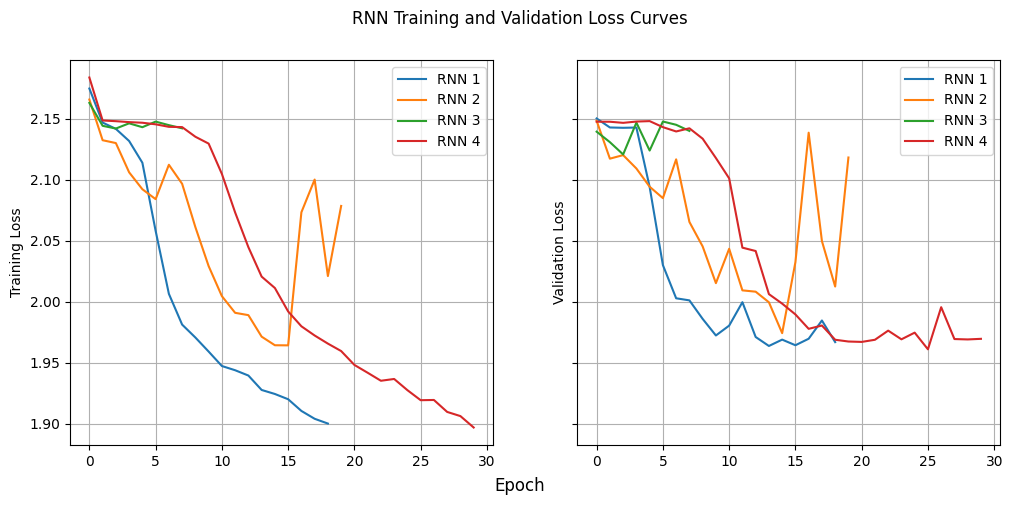

In [ ]:
# rnn training/validation loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

ax1.plot(rnn_1_history.history['loss'], label='RNN 1')
ax1.plot(rnn_2_history.history['loss'], label='RNN 2')
ax1.plot(rnn_3_history.history['loss'], label='RNN 3')
ax1.plot(rnn_4_history.history['loss'], label='RNN 4')
ax1.legend()
ax1.set_ylabel('Training Loss')
ax1.grid()

ax2.plot(rnn_1_history.history['val_loss'], label='RNN 1')
ax2.plot(rnn_2_history.history['val_loss'], label='RNN 2')
ax2.plot(rnn_3_history.history['val_loss'], label='RNN 3')
ax2.plot(rnn_4_history.history['val_loss'], label='RNN 4')
ax2.legend()
ax2.set_ylabel('Validation Loss')
ax2.grid()

fig.suptitle('RNN Training and Validation Loss Curves')
fig.supxlabel('Epoch')
plt.show()

## Takeaways

- The vanilla RNN models generally learn much slower than the baseline models, and they display some signs of overfitting despite performing worse overall
- Architectures with fewer RNN layers give more stable convergence without premature early stopping
- The best vanilla RNN achieves a validation accuracy of **32%** and loss around **1.95**, which is clearly worse than the baseline models